# Test Gauss-Newton plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features, get_correspondences, residual, jacobian, so3_expmap, se3_expmap
from planeslam.geometry.util import skew

%load_ext autoreload
%autoreload 2

torch libraries not found, skipping import


Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

Get correspondences

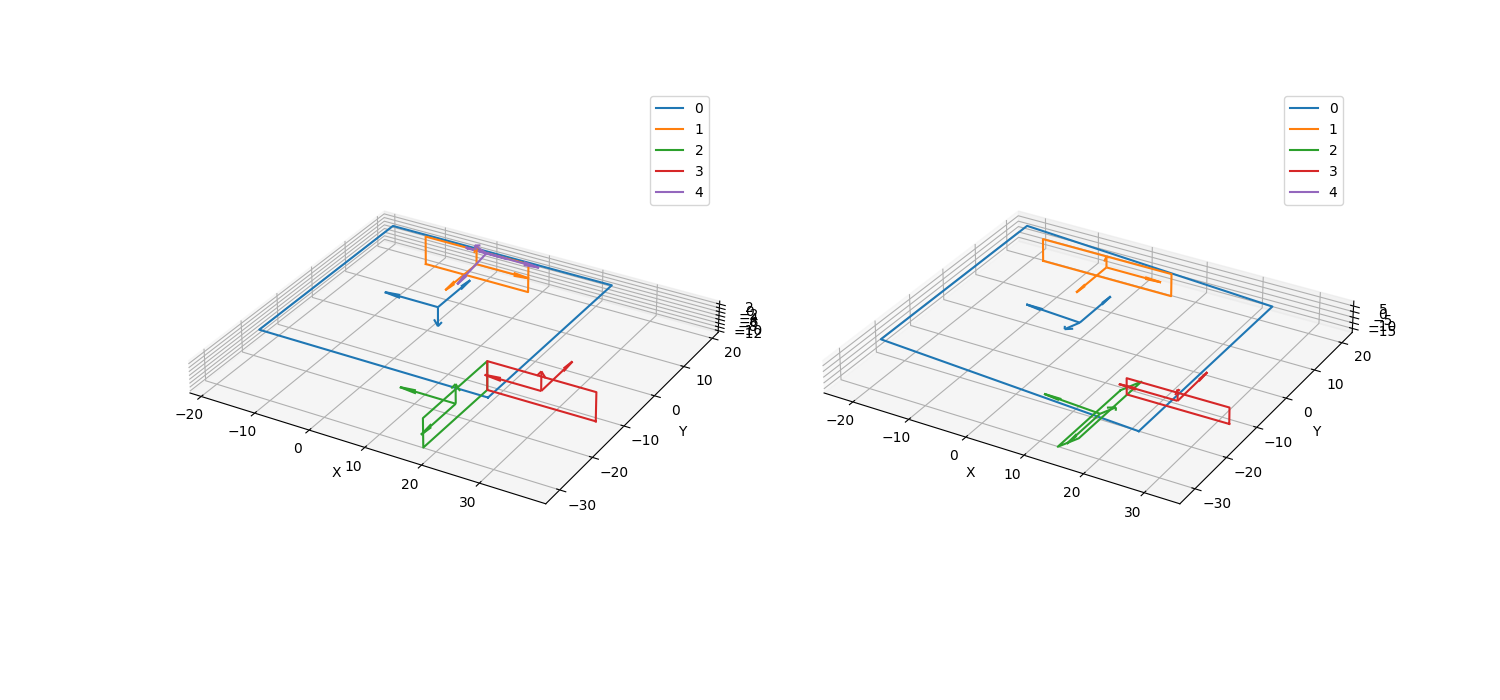

In [5]:
idx_1 = 0
idx_2 = 1

# Plot 2 scans
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax2.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

scans[idx_1].plot(ax1, show_normals=True)
scans[idx_2].plot(ax2, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax1, num_colors)
color_legend(ax2, num_colors)

In [6]:
# Extract normals and distances
# Use idx_2 as source and idx_1 as target
correspondences = get_correspondences(scans[idx_2], scans[idx_1])
#correspondences = [(0,0), (1,1), (2,3), (3,4)]
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[idx_2], scans[idx_1], correspondences)

In [7]:
correspondences

[(0, 0), (1, 1), (2, 2), (3, 3)]

SO(3) optimization

In [8]:
def so3_residual(R, n_s, n_t):
    n_q = (R @ n_s.reshape((3, -1), order='F')).reshape((-1, 1), order='F')
    return n_q - n_t, n_q

def so3_jacobian(n_q):
    N = int(len(n_q) / 3)
    J = np.empty((len(n_q), 3))

    for i in range(N):
        Rn_i =  n_q[3*i:3*i+3].flatten()
        J[3*i:3*i+3,:] = -skew(Rn_i)

    return J

In [9]:
R = np.eye(3)
r, n_q = so3_residual(R, n_s, n_t)
J = so3_jacobian(n_q)

dw = - np.linalg.inv(J.T @ J) @ J.T @ r

: 

: 

In [9]:
R = np.eye(3)

# Gauss-Newton
n_iters = 10
lmbda = 1e-8
mu = 1.0

for i in range(n_iters):
    r, n_q = so3_residual(R, n_s, n_t)
    print("loss: ", np.linalg.norm(r)**2)
    J = so3_jacobian(n_q)
    dw = - mu * np.linalg.inv(J.T @ J + lmbda*np.eye(3)) @ J.T @ r
    R = so3_expmap(dw.flatten()) @ R

: 

: 

Test SE(3) Gauss-Newton registration

In [34]:
# Initial transformation
# t = np.array([0, 1, 0])[:,None]
# u = np.array([1, 0, 0])[:,None]
# theta = 0.1
# #q = np.vstack((t, theta*u))
# q = np.random.randn(6,1)
T = np.eye(4)

# Gauss-Newton
n_iters = 20
lmbda = 0.0
mu = 1.0

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, T)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_s, n_q)
    dv = -mu * np.linalg.inv(J.T @ J + lmbda*np.eye(6)) @ J.T @ r
    T = se3_expmap(dv.flatten()) @ T

# # Gauss-Newton
# n_iters = 10
# lmbda = 1e-8
# mu = 5e-1

# for i in range(n_iters):
#     r, n_q = residual(n_s, d_s, n_t, d_t, q)
#     print("loss: ", np.linalg.norm(r)**2)
#     J = jacobian(n_s, n_q)
#     dq = - mu * np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

loss:  1.0667332871018222
loss:  1.050461922701914
loss:  1.0447935889827356
loss:  1.0489517611282788
loss:  1.0622331688814928
loss:  1.0840213680515653
loss:  1.1137954287610592
loss:  1.1511341641803612
loss:  1.1957165553407239
loss:  1.247319133536624
loss:  1.305811087932455
loss:  1.3711478029287656
loss:  1.4433634265604145
loss:  1.5225629514027654
loss:  1.6089141703613123
loss:  1.7026397622866456
loss:  1.8040096723958137
loss:  1.9133338819799974
loss:  2.030955610280499
loss:  2.157244956671455


Test with two planes

In [ ]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import so3_expmap, se3_expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = so3_expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

In [ ]:
# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

In [ ]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [ ]:
# n_s = P.normal 
# d_s = np.dot(P.normal.flatten(), P.center)
# n_t = Q.normal 
# d_t = np.dot(Q.normal.flatten(), Q.center)
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

In [ ]:
# Initial transformation
# t = np.array([0, 1, 0])[:,None]
# u = np.array([1, 0, 0])[:,None]
# theta = 0.1
# q = np.vstack((t, theta*u))
T = np.eye(4)

# Gauss-Newton
n_iters = 20
lmbda = 1e-8
mu = 0.5

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, T)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_s, n_q)
    dv = - mu * np.linalg.inv(J.T @ J + lmbda*np.eye(6)) @ J.T @ r
    T = se3_expmap(dv.flatten()) @ T

In [ ]:
# Extract R and t from q
t_est = q[:3]
R_est = expmap(q[3:].flatten())
print("t_est: ", t_est)
print("R_est: ", R_est)

# Apply transformation to source
P_T = copy.copy(P)
P_T.transform(R_est, t_est.flatten())

In [ ]:
plot_P = np.vstack((np.eye(3), -np.eye(3)))
ax = plot_3D_setup(P=plot_P)
P_T.plot(ax, color='b')
Q.plot(ax, color='r')

Rotation only

In [ ]:
from planeslam.geometry.util import skew
from planeslam.registration import so3_expmap

In [ ]:
def residual(R, n_s, n_t):
    n_q = (R @ n_s.reshape((3, -1), order='F')).reshape((-1, 1), order='F')
    return n_q - n_t, n_q

def jacobian(n_q):
    N = int(len(n_q) / 3)

    J = np.empty((3*N,3))
    for i in range(N):
        Rn_i = n_q[3*i:3*i+3].flatten()
        J[3*i:3*i+3,:] = -skew(Rn_i)
    
    return J

In [ ]:
n_s = np.array([1,2,3, 1,2,1, -1,1,2])[:,None]

R_gt = so3_expmap([0, 0.5, 0])
n_t = (R_gt @ n_s.reshape((3, -1), order='F')).reshape((-1, 1), order='F')

In [ ]:
R = np.eye(3)
mu = 1.0
lmbda = 1e-5

for i in range(10):
    r, n_q = residual(R, n_s, n_t)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_q)
    dw = -mu * np.linalg.inv(J.T @ J + lmbda*np.eye(3)) @ J.T @ r
    R = so3_expmap(dw.flatten()) @ R

In [ ]:
R

In [ ]:
R_gt